# Optimal Growth Model using Endogenous grid method.
EGM is faster than smart VFI if the grid size is larger than roughly 300 for my little experience. It means we should use EGM, if we consider stochastic dynamic programming.

This explanation is  my reminder and may have some mistakes.
- What is Endogenous Grid Method(EGM)?

In many solution methods, we discretize **state space**. 

However, we discretize **choice space** in EGM and compute state value under grid for optimal choice.

This method uses Euler equation. So it is similar to Time Iteration method.

What we do is the following step.
    1. discretize tomorrow's capital grid and guess policy function(from wealth to k')
    2. compute today's wealth using Euler equation.
    3. update guess and iterate until it converges.
    
 **IMPORTANT!!**
 
 If we use EGM, we can avoid  to use nonlinear solver in iteration.
 We need to use nonlinear solver just once after iteration is finished.
 
 This property makes run time faster than ever.

## Theory
We assume marginal utility function is invertible.

- Consider Euler equation

$$u'(c) = \beta u'(c')[f'(k')+(1-\delta)]$$

- Use the resource constraint $c +k' = f(k) +(1-\delta)k$, and policy $p(k')=k^{\prime\prime}$



$$u'(c) =\beta u'(f(k')+(1-\delta)k' -p(k'))[f'(k') +(1-\delta)]$$

- Consumption can be written as 

$$c =u^{\prime -1}\left[ \beta u'\left(f(k')+(1-\delta)k' -p(k')\right)[f'(k') +(1-\delta)]\right]$$

- Combine this with resource constraint,

$$u^{\prime -1}\left[ \beta u'\left(f(k')+(1-\delta)k' -p(k')\right)[f'(k') +(1-\delta)]\right] + k' = f(k) + (1-\delta)k$$


To avoid root finding, we consider the total resource as a state variable.

We define wealth as $w = f(k) +(1-\delta)k$ and consider policy function maps wealth to capital choice,
$k' = p(w)$.

- Rearrange equation (4) using wealth notation and new policy function


$$k' +u^{\prime -1}\left[ \beta u'\left(w' -p(w')\right)[f'(k') +(1-\delta)]\right] = w$$


## EGM Algorithm

### Set up the situation
1. discretize choice state K' =$[K'_1, ...,K'_n]$
2. guess policy function from wealth to capital in the next period.: $p:[w_1, ....w_n] →[K'_1,...,K'_n] $
3. set maximum number of iteration and error tolerance

### Iteration
1. For all $1\le j \le n$ , set $k' = K'_j$ and  $w' = f(k')+(1-\delta)k$ and 
compute today's wealth given policy and tomorrow's capital

$$w_j = k' +u^{\prime -1}\left[ \beta u'\left(w' -p(w')\right)[f'(k') +(1-\delta)]\right]$$

**Reminder**: Our policy guess' domain is **today's wealth**, so we need to reevaluate **tomorrow's wealth** 

2. update policy and compute error

3. if error < tolerance, iteration is over. otherwise, continue iteration. 

**For my understanding**

Policy function can be determined implicitly. This is because we compute today's wealth by using exogenous tomorrow's capital grid and  this relationship between wealth and capial is a policy function. So update policy means  update today's wealth grid.

In [1]:
using QuantEcon
using Roots
using BenchmarkTools
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
mutable struct Model{TI<:Integer, TF<:AbstractFloat}
    β::TF
    γ::TF
    δ::TF
    α::TF
    nk::TI
    kpgrid::Array{TF,1}
    wgrid ::Array{TF,1}
    u::Function
    u′::Function
    u′_inv::Function
    f::Function
    f′::Function
end

function Model(β=0.95, # subjective discount factor
                γ=2.0, # risk aversion
                δ=0.1, # depriciation rate
                α=0.33, # capital share
                nk=250,# Number of grid point
                )
    
    # set utility function
    u(c::Float64) = (c^(1.0-γ))/(1.0-γ)
    u′(c::Float64) = c^(-γ)
    u′_inv(val::Float64) = val^(-1.0/γ)
    # production function
    f(k::Float64) =  k^α 
    f′(k::Float64) = α*k^(α-1.0) 
    
    

    #create capital grid
    kstar=((1.0/β-(1-δ))/α)^(1.0/(α-1.0)) #steady state capital stock
    kmin = 0.1*kstar # minimal capital stock
    kmax = 2.0*kstar # maximal capital stock
    kpgrid = collect(linspace(kmin,kmax,nk)) # capital grid in the next period

    #create cash in hand grid 
    wmin = f(kmin) + (1-δ)*kmin # minimal wealth
    wmax = f(kmax) + (1-δ)*kmax # maximal wealth
    wgrid = collect(linspace(wmin,wmax,nk)) # create grid between w_min and w_max with nk gridpoints

    if γ == 1.0   # when γ==1.0, we assume log utility 
        u_log(c) = log(c)
        m = Model(β, γ, δ, α, nk, kpgrid, wgrid, u_log, u′,u′_inv, f, f′)
    else
        m = Model(β, γ, δ, α, nk, kpgrid, wgrid, u, u′,u′_inv , f,  f′)
    end
    
    return m
end

Model

In [3]:
m = Model()

Model{Int64,Float64}(0.95, 2.0, 0.1, 0.33, 250, [0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172], [0.968288, 0.994629, 1.02097, 1.04731, 1.07365, 1.09999, 1.12634, 1.15268, 1.17902, 1.20536  …  7.29018, 7.31652, 7.34286, 7.36921, 7.39555, 7.42189, 7.44823, 7.47457, 7.50091, 7.52725], u, u′, u′_inv, f, f′)

In [4]:
function EGM(m::Model)
    const β = m.β
    const γ = m.γ
    const δ = m.δ
    const α = m.α
    const nk = m.nk
    kpgrid = m.kpgrid
    wgrid  = m.wgrid
    u = m.u
    u′= m.u′
    u′_inv = m.u′_inv
    f = m.f
    f′= m.f′

    Tw::Array{Float64,1} = zeros(nk)
    const tol_it = 1e-5 
    const maxiter = 10000
    
    #wp::Float64 =0.0
    wp::Array{Float64,1} = zeros(nk)
    #kp::Float64 =0.0
    
    for iter in 1:maxiter    
        p = LinInterp(wgrid, kpgrid)
        
        # Vectorize code This is faster than loop.
        wp .= f.(kpgrid) +(1.0-δ)*kpgrid
        Tw .= kpgrid .+ u′_inv.(β*u′.(wp-p.(wp)).*(f′.(kpgrid) +(1.0 -δ)))
        
        #for i in 1:nk # loop over all gridpoints
        #    kp =  kpgrid[i] # read grid point to be considered
            # compute tomorrow's wealth
        #    wp  = f(kp)+(1.0-δ)*kp
            # get today's wealth w from choice kp
        #    @inbounds Tw[i] = kp + u′_inv(β*u′(wp-p(wp))*(f′(kp) +(1.0 -δ)))
        #end
        

        # Calculate error
        error_it=maximum(abs.(wgrid-Tw))/(maximum(abs.(wgrid)))
        # Update policy
        wgrid=copy(Tw)
        
        if error_it < tol_it
            break
        end
    
    end
    
    #Compute today's capital grid that is endogenously determined.
    kend = zeros(nk) 
    
    for i in 1:nk
        object(x) = wgrid[i] - x^α -(1.0-δ)*x 
        @inbounds kend[i]= newton(object,kpgrid[i])
    end
    itp = LinInterp(kend,kpgrid)
    policy = itp.(kpgrid) # policy function 
    # we can consider kpgrid as today's capital grid.
    
    return wgrid,kpgrid,policy
end


EGM (generic function with 1 method)

In [5]:
wgrid, kgrid, pol_k = EGM(m)

([0.700506, 0.738619, 0.776187, 0.813267, 0.849904, 0.886139, 0.922006, 0.957535, 0.992751, 1.02768  …  7.67631, 7.70344, 7.73057, 7.7577, 7.78481, 7.81193, 7.83903, 7.86613, 7.89323, 7.92032], [0.316086, 0.340205, 0.364324, 0.388443, 0.412562, 0.436681, 0.4608, 0.484919, 0.509038, 0.533157  …  6.10465, 6.12877, 6.15289, 6.17701, 6.20113, 6.22524, 6.24936, 6.27348, 6.2976, 6.32172], [0.492232, 0.518679, 0.544821, 0.57069, 0.596314, 0.621715, 0.646916, 0.671934, 0.696783, 0.721479  …  5.78027, 5.80161, 5.82294, 5.84427, 5.8656, 5.88693, 5.90826, 5.92959, 5.95092, 5.97224])

In [6]:
@time EGM(m);

  0.017660 seconds (34.49 k allocations: 2.297 MiB)



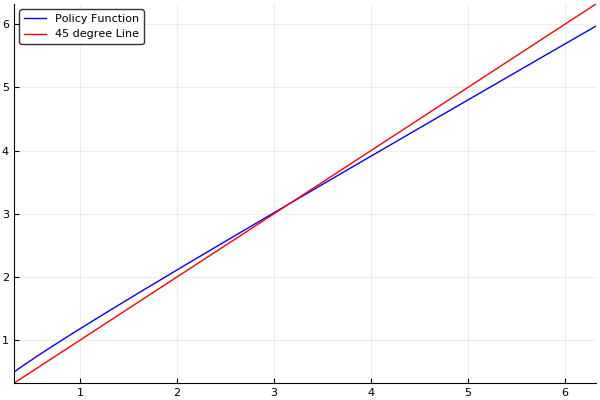

In [7]:
plot(kgrid,pol_k, color="blue", label="Policy Function")
plot!(kgrid,kgrid, color="red", label="45 degree Line")

In [8]:
@benchmark EGM(m) 

BenchmarkTools.Trial: 
  memory estimate:  2.29 MiB
  allocs estimate:  34407
  --------------
  minimum time:     13.414 ms (0.00% GC)
  median time:      26.399 ms (0.00% GC)
  mean time:        27.433 ms (3.40% GC)
  maximum time:     47.667 ms (0.00% GC)
  --------------
  samples:          183
  evals/sample:     1